In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv', low_memory=False)
df['localminute'] = df['localminute'].apply(lambda x: x[0:19])
df = df.sort_values(by=['dataid', 'localminute'])
print(df.nunique())

localminute    1499587
dataid             157
meter_value     144001
dtype: int64


In [3]:
#create some data with Names column
data = df
#create unique list of names
UniqueNames = data.dataid.unique()
#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data.dataid == key]   

In [4]:
def checkValidility(input_df):
    input_df.reset_index(drop=True, inplace=True)
    meterValues = np.array(input_df['meter_value'])
    prevVal = -1
    for i in range(len(meterValues)):
        currVal = meterValues[i]
        if currVal < prevVal:
            return False
        
        prevVal = currVal
    
    return True

def checkIdle(input_df):
    input_df.reset_index(drop=True, inplace=True)
    meterValues = np.array(input_df['meter_value'])
    meterTime = np.array(input_df['localminute'])

    idleTime = pd.Timedelta(0, unit='days')
    idleTimeCriterion = pd.Timedelta(30, unit='days')
    i = 0
    j = 0

    while i < len(meterValues) and j != len(meterValues) - 1:
        for j in range(i, len(meterValues)):
            if meterValues[i] != meterValues[j]:
                break
            else:
                idleTime = pd.to_datetime(meterTime[j]) - pd.to_datetime(meterTime[i])
                if idleTime > idleTimeCriterion:
                    return False
        i = j
    return True

def checkOverallValidility(df):
    #create some data with Names column
    data = df
    #create unique list of names
    UniqueNames = data.dataid.unique()
    #create a data frame dictionary to store your data frames
    DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
    for key in DataFrameDict.keys():
        DataFrameDict[key] = data[:][data.dataid == key]
    
    mulfunctionHouses = []
    for house in UniqueNames:
        house_df = DataFrameDict[house]
        
        if checkValidility(house_df) == False or checkIdle(house_df) == False:
            mulfunctionHouses.append(house)
    return mulfunctionHouses

In [5]:
mulfuncHouses = checkOverallValidility(df)

In [134]:
print(mulfuncHouses)
len(mulfuncHouses)

[35, 77, 94, 483, 484, 1042, 1086, 1185, 1507, 1556, 1718, 1790, 1801, 2129, 2335, 2449, 3134, 3527, 3544, 3893, 4031, 4193, 4447, 4514, 4998, 5129, 5131, 5193, 5403, 5810, 5814, 5892, 6836, 7017, 7030, 7117, 7739, 7794, 7989, 8156, 8890, 8967, 9134, 9639, 9982]


45

### Q1.2

In [7]:
len(mulfuncHouses)

45

In [25]:
def removeAnomaly(input_df, mulfuncHouses):
    #create some data with Names column
    data = input_df
    #create unique list of names
    UniqueNames = data.dataid.unique()
    #create a data frame dictionary to store your data frames
    DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames if elem not in mulfuncHouses}
    for key in DataFrameDict.keys():
        if key not in mulfuncHouses:
            DataFrameDict[key] = data[:][data.dataid == key]
    return DataFrameDict

In [89]:
cleanedData = removeAnomaly(df, mulfuncHouses)

In [90]:
for key in cleanedData.keys():
    cleanedData[key] = cleanedData[key].drop(columns=['dataid'])
    cleanedData[key] = cleanedData[key].rename(columns={'meter_value': key})
    
    testData = cleanedData[key]
    testData['localminute'] = pd.to_datetime(testData['localminute'])
    testData = testData.set_index('localminute')
    hourlySampledData = testData.resample("1H").mean()
    cleanedData[key] = hourlySampledData.fillna(method='pad')

In [109]:
def joinTables(cleanedData):
    combined = cleanedData[44]
    for key in cleanedData.keys():
        if key != 44:
            combined = combined.join(cleanedData[key], how='left')
    return combined
        

In [110]:
combinedData = joinTables(cleanedData)
combinedData = combinedData.dropna(axis='columns')
combinedData -= combinedData.iloc[0]

In [139]:
def getTimeRange(combinedData, startDate, endDate):
    start_date = pd.to_datetime(startDate)
    end_date = pd.to_datetime(endDate)
    mask = (combinedData.index > start_date) & (combinedData.index <= end_date)
    
    monthData = combinedData.loc[mask]
    return monthData
    
    

In [141]:
monthData = getTimeRange(combinedData, '2015-10-12', '2015-11-12')

,44,114,187,222,252,370,661,739,744,871,...,9052,9121,9278,9295,9474,9631,9729,9766,9849,mean
localminute,,,,,,,,,,,,,,,,,,,,,
2015-10-12 18:00:00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2015-10-12 19:00:00,0.000000,2.0,0.0,0.000000,0.000000,0.000000,2.0,0.000000,4.000000,0.000000,...,2.0,2.000000,0.0,7.066667,0.000000,5.000000,0.0,0.0,0.000000,1.896197
2015-10-12 20:00:00,0.000000,3.0,0.0,15.333333,24.000000,1.000000,2.0,0.000000,6.000000,0.000000,...,2.0,8.000000,0.0,14.114286,0.000000,6.000000,0.0,0.0,4.000000,4.552492
2015-10-12 21:00:00,10.000000,4.0,0.0,16.000000,24.000000,1.000000,2.0,0.000000,6.000000,0.000000,...,12.0,10.400000,0.0,18.400000,0.000000,10.000000,0.0,0.0,6.000000,6.069692
2015-10-12 22:00:00,10.000000,4.0,0.0,16.000000,24.000000,2.000000,2.0,2.000000,32.666667,0.000000,...,12.0,16.000000,0.0,28.400000,2.000000,10.000000,2.0,0.0,6.000000,7.185829
2015-10-12 23:00:00,12.000000,4.0,0.0,16.000000,24.000000,2.000000,2.0,2.000000,34.000000,0.000000,...,12.0,16.000000,0.0,28.400000,2.000000,10.000000,2.0,0.0,6.000000,7.527099
2015-10-13 00:00:00,12.000000,4.0,0.0,16.000000,24.000000,2.000000,3.0,2.000000,34.000000,0.000000,...,14.0,18.000000,0.0,29.200000,2.000000,10.000000,2.0,0.0,6.000000,8.251702
2015-10-13 01:00:00,12.000000,4.0,0.0,18.000000,26.000000,2.000000,3.0,2.000000,34.000000,0.000000,...,14.0,20.000000,0.0,30.400000,2.000000,10.000000,2.0,0.0,6.000000,9.008484
2015-10-13 02:00:00,12.000000,4.0,0.0,18.000000,26.000000,2.000000,3.0,2.000000,34.000000,0.000000,...,14.0,20.000000,0.0,30.400000,2.000000,10.000000,2.0,0.0,6.000000,9.531861


In [189]:
def plotGasData(combinedData):
    combinedData['mean'] = combinedData.mean(axis=1)
    gasMean = np.array(combinedData['mean'])
    gasTime = np.array(combinedData.index)
    minIdx = monthData.iloc[[-1]].idxmin(1)[0]
    maxIdx = monthData.iloc[[-1]].idxmax(1)[0]
    gasMin = monthData[minIdx]
    gasMax = monthData[maxIdx]
    
    fig=plt.figure(figsize=(30,15), dpi= 200, facecolor='w', edgecolor='k')
    plt.yscale('linear')
    plt.plot(gasTime, gasMean, label = 'Average')
    plt.plot(gasTime, gasMin, label = 'Min')
    plt.plot(gasTime, gasMax, label = 'Max')
    plt.legend()
    

/Users/jyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


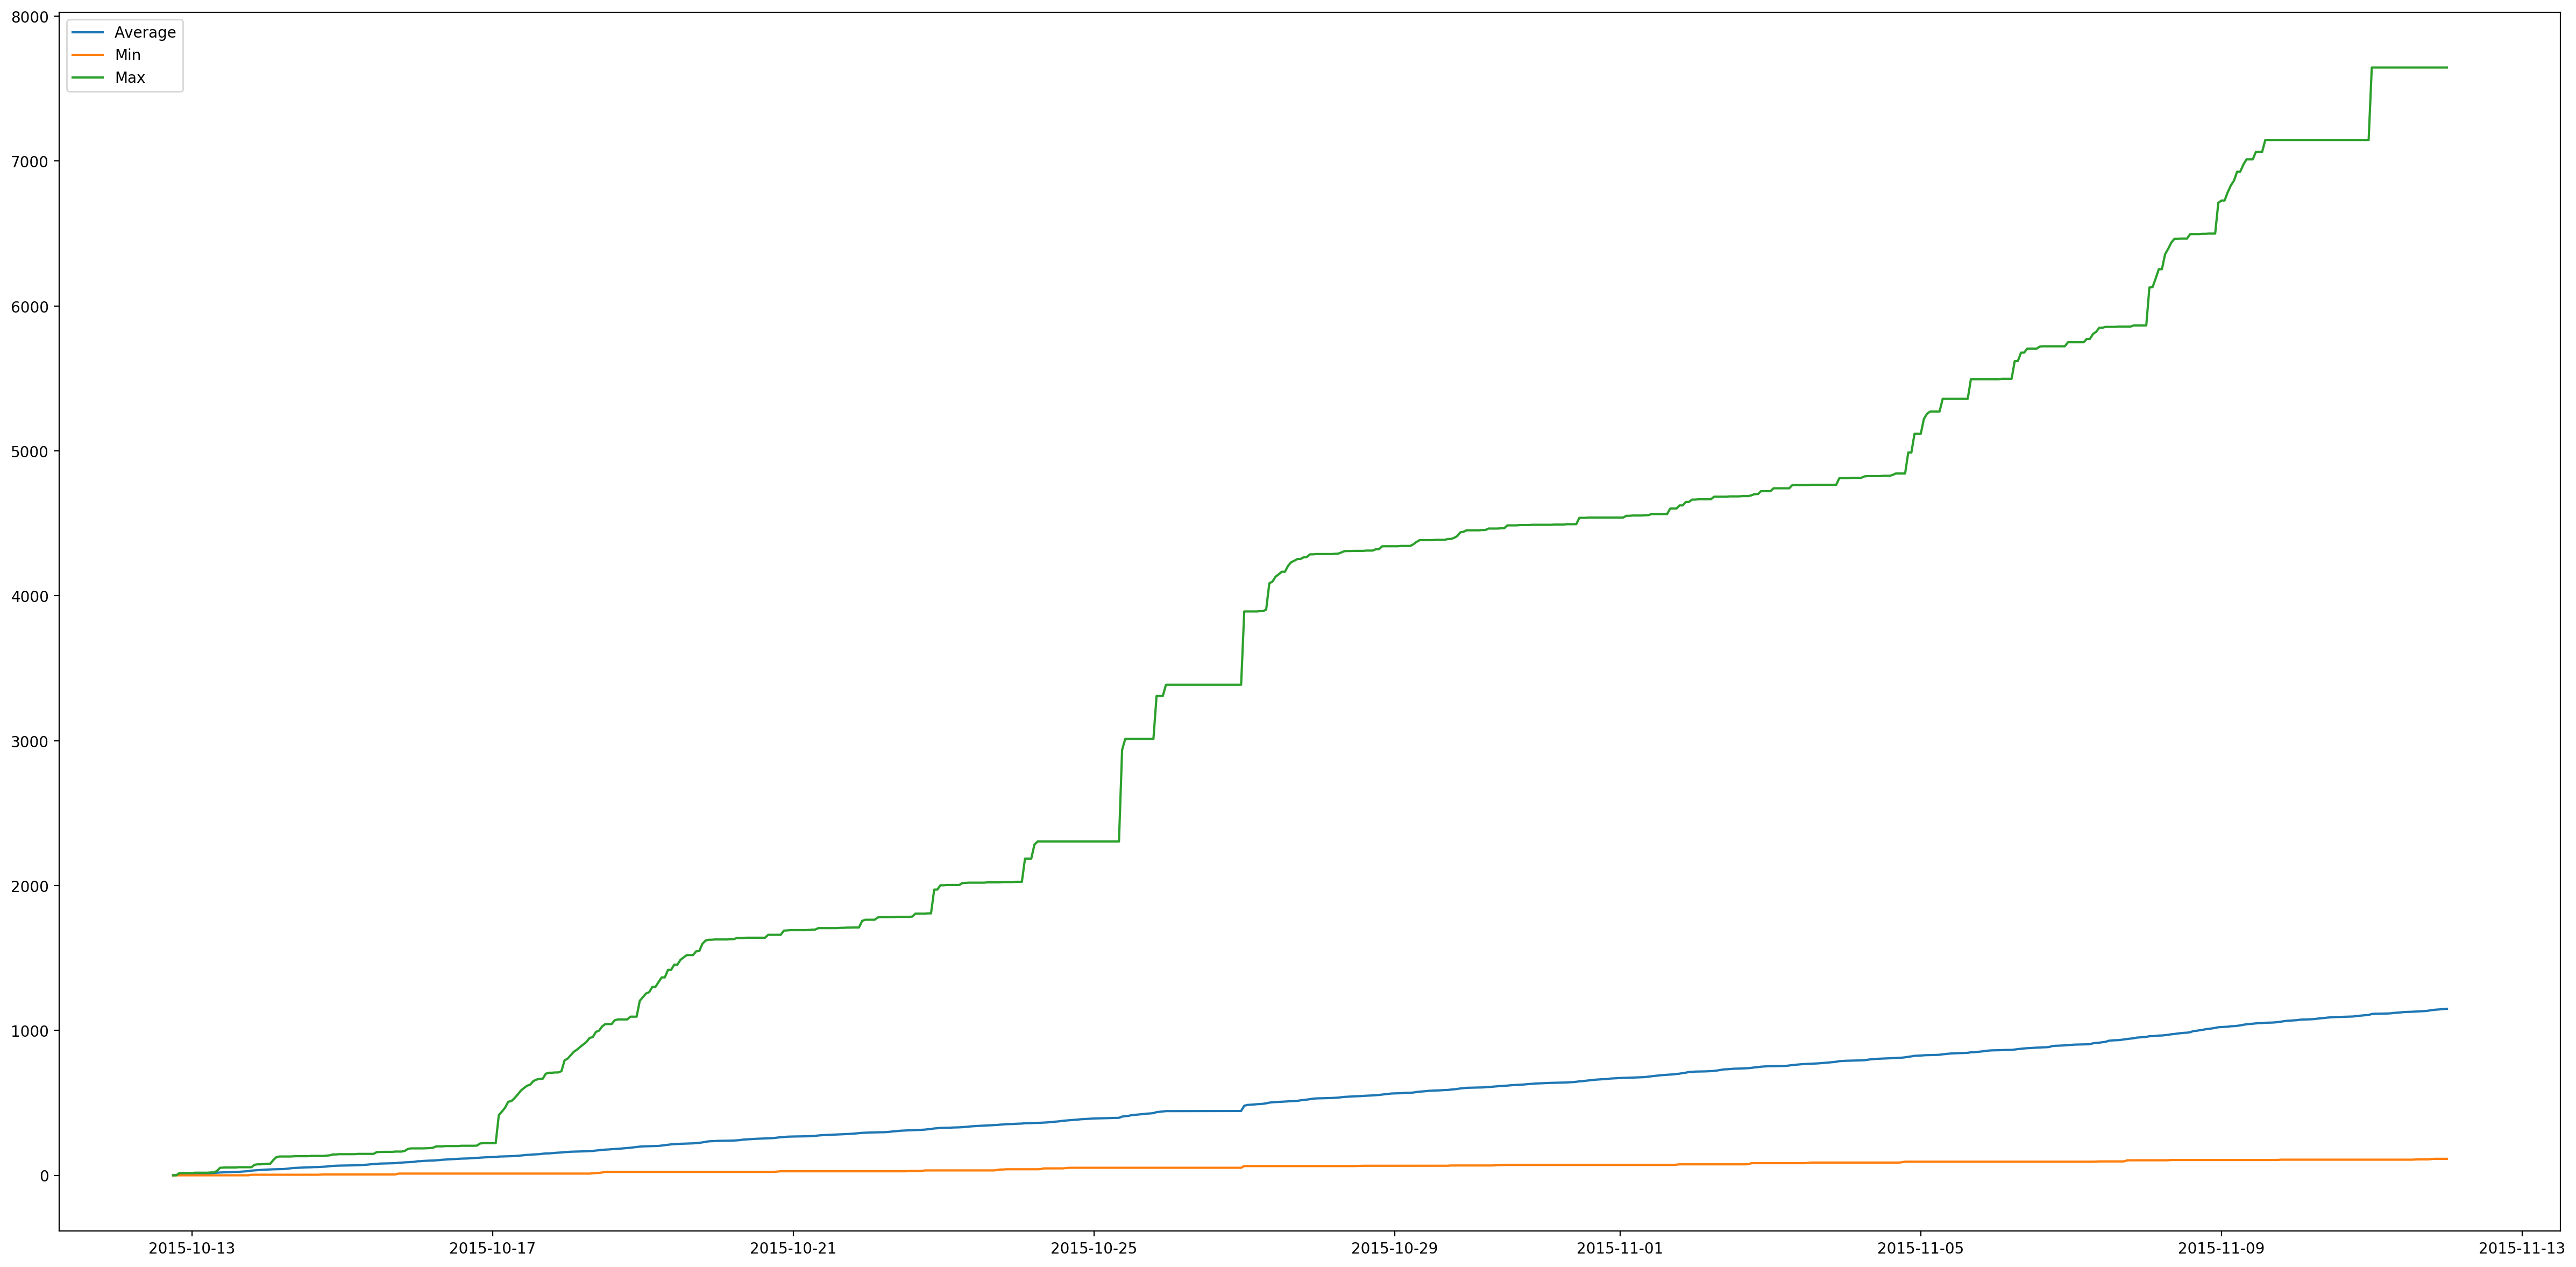

In [190]:
plotGasData(monthData)

localminute
2015-10-12 18:00:00      0.000000
2015-10-12 19:00:00      0.000000
2015-10-12 20:00:00      0.000000
2015-10-12 21:00:00      0.000000
2015-10-12 22:00:00      0.000000
2015-10-12 23:00:00      0.000000
2015-10-13 00:00:00      0.000000
2015-10-13 01:00:00      0.000000
2015-10-13 02:00:00      0.000000
2015-10-13 03:00:00      0.000000
2015-10-13 04:00:00      0.000000
2015-10-13 05:00:00      0.000000
2015-10-13 06:00:00      0.000000
2015-10-13 07:00:00      0.000000
2015-10-13 08:00:00      0.000000
2015-10-13 09:00:00      0.000000
2015-10-13 10:00:00      0.000000
2015-10-13 11:00:00      0.000000
2015-10-13 12:00:00      0.000000
2015-10-13 13:00:00      0.000000
2015-10-13 14:00:00      0.000000
2015-10-13 15:00:00      0.000000
2015-10-13 16:00:00      0.000000
2015-10-13 17:00:00      0.000000
2015-10-13 18:00:00      0.250000
2015-10-13 19:00:00      4.000000
2015-10-13 20:00:00      4.000000
2015-10-13 21:00:00      4.000000
2015-10-13 22:00:00      4.000000
20